### Replication power simulation

Strategy:

- sample subjects from wessel replication 1 in order to create a dataset with particular N (using fabricatr
- fit lmer to dataset 
- create 3 simulated datasets using appropriate value for interaction beta
- run models on simulated datasets after combining across sites (simulating our 3 sites)
- store pvalue and cohen's d for observed effect


In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
import seaborn as sns
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
import time
import pickle 

pandas2ri.activate()
lme4 = importr('lme4')
stats = importr('stats')
lmerTest = importr('lmerTest')
EMAtools = importr('EMAtools')
fabricatr = importr('fabricatr')
%load_ext rpy2.ipython



/opt/conda/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Load the data

In [2]:
%%R -o rep1Df

library('tidyverse')
rep1Df = read_delim('../processed_data/study-1_task-auction_data.tsv', '\t')
rep1Df['X1'] = NULL
rep1Df = rep1Df %>% 
  mutate(studyNum = 1,
         stimValueFactor = as.factor(auctionStimValue))


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()

R[write to console]: Parsed with column specification:
cols(
  X1 = col_double(),
  auctionStimValue = col_double(),
  auctionCondition = col_character(),
  chosenAuctionAmount = col_double(),
  subcode = col_character()
)



In [3]:
# function to run ezANOVA on the summary data

run_ez = r('''run_ez = function(summaryDf){
library(ez)
summaryDf['auctionStimValue'] = as.factor(summaryDf$auctionStimValue)
summaryDf['auctionCondition'] = as.factor(summaryDf$auctionCondition)
summaryDf['site'] = as.factor(summaryDf$site)
summaryDf['subcode_unique'] = as.factor(summaryDf$subcode_unique)

#Run an ANOVA on the mean correct RT data.
CombinedExclusiveAuctionANOVA = ezANOVA(
  data = summaryDf
  , dv = chosenAuctionAmount
  , wid = subcode_unique
  , within = .(auctionStimValue,auctionCondition)
  , between = site
  , detailed = TRUE
)
}
''')

Now we loop through the main simulation runs.  on each round we generate a simulated dataset for each site (by resampling from the existing dataset using `fabricatr` and then simulating using lme4 `simulate()`), and then we fit three models:
- full mixed model using `lmer()` with random intercept and interaction slope
- mixed model on summary data for each subject, with random intercept (i.e. treating slope as fixed effect)
- standard repeated measures ANOVA model on summary data, using ezANOVA (with Huhyn-Feldt correction for nonsphericity)

In [4]:
# formulas for lmer analyses

testmode = True

# full mixed model with random intercept and interaction slope
formula = """chosenAuctionAmount ~ 
              auctionStimValue*auctionCondition + 
              (1 + auctionStimValue*auctionCondition|subcode_unique)"""

# multisite mixed model with site interaction
formula_multisite = """chosenAuctionAmount ~ 
              site*auctionStimValue*auctionCondition + 
              (1 + auctionStimValue*auctionCondition|subcode_unique)"""

# formula for random intercept model on summary data
formula_summary = """chosenAuctionAmount ~ 
              site*auctionStimValue*auctionCondition + 
              (1 |subcode_unique)"""

n = 79  # N determined by previous power analysis

# since we can't specify a standardized effect size, we randomly select
# the interaction parameter from within this range (based on pilot simulations)
# and then compute the observed cohen's D for the analysis
int_param_max = 3.5
int_param_min = 1

results_sim = pd.DataFrame(columns=['int_param', 'cohensd_int', 'int_pval'])

if testmode:
    nruns=1
else:
    nruns = 1000
now = time.time()
et = []

# use a specific seed to get reproducible results
rng = np.random.RandomState(1)

# not sure if this actually works for fabricatr
r('set.seed(1)')

# store full results to a dictionary
results_sim_full = {}

for i in range(nruns):
    results_sim_full[i] = {}
    # choose an interaction parameter from within the range of interest
    int_param = int_param_min + np.random.rand()*(int_param_max - int_param_min)
    
    # print a progress report with ETA
    if i > 0:
        et.append(time.time() - now)
        print(i, int_param, et[-1], 'eta:', (nruns - i)*np.mean(et)/60, 'mins')
        now = time.time()
    
    # resample data from original, by subject
    simDf = fabricatr.resample_data(rep1Df, n, r("c('subcode')"), True)
    
    # fit mixed model to original dataset, to estimate random effects
    m1 = lme4.lmer(formula=formula, data=simDf)

    # set coefs, with fixed intercept and main effect and 
    # varying interaction parameter
    coefs=r('list(beta=c(139,10,0,%f))' % int_param)
    
    # create simulated data for the three sites using the fitted model
    # with the new coefficients
    s = lme4.simulate_merMod(m1, newparams=coefs, nsim=3, seed=rng.randint(0,10000))
    simDf1 = simDf.copy()
    simDf2 = simDf.copy()
    simDf3 = simDf.copy()
    simDf1['chosenAuctionAmount'] = s.sim_1.values
    simDf2['chosenAuctionAmount'] = s.sim_2.values
    simDf3['chosenAuctionAmount'] = s.sim_3.values
    simDf1['site'] = 'a'
    simDf2['site'] = 'b'
    simDf3['site'] = 'c'
    # need to create new unique subcodes across sites
    simDf1['subcode_unique'] = ['%s_a' % i for i in simDf1['subcode_unique']]
    simDf2['subcode_unique'] = ['%s_b' % i for i in simDf2['subcode_unique']]
    simDf3['subcode_unique'] = ['%s_c' % i for i in simDf3['subcode_unique']]
  
    simDfall = simDf1.append(simDf2).append(simDf3)
    
    # fit full mixed model to combined data
    # do not include site random effect as it is accounted for by subject
    sm1 = lme4.lmer(formula=formula_multisite, data=simDfall)
    sm1_coefs = lmerTest.get_coefmat(sm1)
    results_sim.loc[i, 'int_pval'] = sm1_coefs[9,4]
    results_sim.loc[i, 'cohensd_int'] = EMAtools.lme_dscore(
        sm1, simDfall, 'lme4').loc['auctionStimValue:auctionConditionstop', 'd']
    results_sim.loc[i, 'int_param'] = int_param
    results_sim_full[i]['lmer_full'] = {'coefs': sm1_coefs,
                                        'summary': lmerTest.summary_merModLmerTest(sm1)}
    
    # create summary data for simple repeated measures analyses
    summaryDf = simDfall.groupby(['subcode_unique', 'site',
                               'auctionStimValue', 
                               'auctionCondition']).mean().reset_index()

    # use ezanova
    ez = run_ez(summaryDf)
    results_sim.loc[i, 'int_pval_ez'] = ez[2].query(
        'Effect=="auctionStimValue:auctionCondition"').loc[:, "p[HF]"].values[0]
    results_sim_full[i]['ez'] = ez
    
    # fit lmer model with random intercept to summary data
    sm3 = lme4.lmer(formula=formula_summary, data=summaryDf)
    sm3_coefs = lmerTest.get_coefmat(sm3)
    results_sim.loc[i, 'int_pval_simple'] = sm3_coefs[3,4]
    results_sim.loc[i, 'cohensd_int_simple'] = EMAtools.lme_dscore(
        sm3, summaryDf, 'lme4').loc[
            'auctionStimValue:auctionConditionstop', 'd']
    results_sim_full[i]['lmer_summary']={'coefs': sm3_coefs,
                                        'summary': lmerTest.summary_merModLmerTest(sm3)}

if not testmode:
    results_sim.to_csv('power_sim_mixedmodel1.csv')
    with open('power_sim_mixedmodels.pkl', 'wb') as f:
        pickle.dump(results_sim_full, f)

R[write to console]: theta parameter vector not named: assuming same order as internal vector

R[write to console]: beta parameter vector not named: assuming same order as internal vector

R[write to console]: Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4



In [ ]:
# load pkl and get proper p values for interaction

with open('power_sim_mixedmodels.pkl', 'rb') as f:
    results_all = pickle.load(f)
    
    

In [ ]:
results_all.keys()

In [4]:
results_sim = pd.read_csv('power_sim_mixedmodel1.csv')
results_sim['psig_int'] = (results_sim['int_pval'] < .05).astype("int")
results_sim['psig_int_ez'] = (results_sim['int_pval_ez'] < .05).astype("int")
results_sim['psig_int_rm'] = (results_sim['int_pval_simple'] < .05).astype("int")
#sns.scatterplot(x='cohensd_int', y='psig_int', data=results_sim)

In [5]:
# use moving average
dvals = np.arange(0, 1, .025)
span = .025
power_ma = pd.DataFrame()
for i, d in enumerate(dvals):
    results_d = results_sim.query('cohensd_int > %f & cohensd_int < %f' % (d - span, d + span))
    power_ma.loc[i, 'd'] = d
    power_ma.loc[i, 'power_randslope'] = results_d.psig_int.mean()
    power_ma.loc[i, 'power_rm'] = results_d.psig_int_rm.mean()
    power_ma.loc[i, 'power_ez'] = results_d.psig_int_ez.mean()
    power_ma.loc[i, 'n'] = results_d.psig_int.count()
    
print('full mixed model: exceeds 80% power for d = ', power_ma.query('power_randslope > 0.8').d.iloc[0])
print('mixed model on summary : exceeds 80% power for d = ', power_ma.query('power_rm > 0.8').d.iloc[0])
print('ezANOVA: exceeds 80% power for d = ', power_ma.query('power_ez > 0.8').d.iloc[0])

full mixed model: exceeds 80% power for d =  0.0
mixed model on summary : exceeds 80% power for d =  0.0
ezANOVA: exceeds 80% power for d =  0.30000000000000004


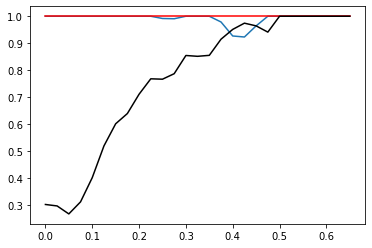

In [6]:
plt.plot(power_ma.d, power_ma.power_randslope)
plt.plot(power_ma.d, power_ma.power_rm, 'r')
plt.plot(power_ma.d, power_ma.power_ez, 'k')


In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(results_sim.cohensd_int[:, np.newaxis], results_sim.int_param)
print(lr.coef_, lr.intercept_)

lr.intercept_ + lr.coef_[0]*.2

In [ ]:
lr.predict(np.array([.5]).reshape((1,1)))

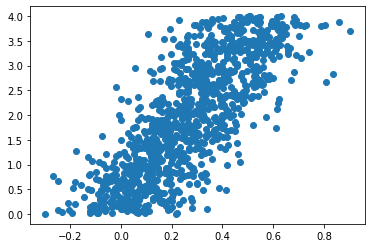

In [13]:
plt.scatter(results_sim.cohensd_int, results_sim.int_param)